In [1]:
# Importing Libraries

import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch import nn
from torch.functional import F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor

import math

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
# Loading data into DataLoader

train_data = torchvision.datasets.CIFAR100(root = './data', train = True, transform = transform, download = True)
train_data = torchvision.datasets.CIFAR100(root = './data', train = False, transform = transform, download = True)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = False)

100%|██████████| 169001437/169001437 [00:08<00:00, 20542948.15it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
print(len(train_loader.dataset), "\n", len(test_loader.dataset))

for data,label in train_loader:
    print(data.shape, label.shape)
    break

10000 
 10000
torch.Size([64, 3, 32, 32]) torch.Size([64])


In [5]:
# Checking class names

cifar100 = datasets.CIFAR100(root = './data')
class_names = cifar100.classes
print(class_names)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [6]:
# Creating Model

class Bottleneck(nn.Module):
    def __init__(self, in_planes, growth_rate):
        super(Bottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, 4*growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4*growth_rate)
        self.conv2 = nn.Conv2d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out = self.conv1(F.relu(self.bn1(x)))
        out = self.conv2(F.relu(self.bn2(out)))
        out = torch.cat([out,x], 1)
        return out


class Transition(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Transition, self).__init__()
        self.bn = nn.BatchNorm2d(in_planes)
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.conv(F.relu(self.bn(x)))
        out = F.avg_pool2d(out, 2)
        return out


class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_classes=100):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv2d(3, num_planes, kernel_size=3, padding=1, bias=False)

        self.dense1 = self._make_dense_layers(block, num_planes, nblocks[0])
        num_planes += nblocks[0]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans1 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense2 = self._make_dense_layers(block, num_planes, nblocks[1])
        num_planes += nblocks[1]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans2 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense3 = self._make_dense_layers(block, num_planes, nblocks[2])
        num_planes += nblocks[2]*growth_rate
        out_planes = int(math.floor(num_planes*reduction))
        self.trans3 = Transition(num_planes, out_planes)
        num_planes = out_planes

        self.dense4 = self._make_dense_layers(block, num_planes, nblocks[3])
        num_planes += nblocks[3]*growth_rate

        self.bn = nn.BatchNorm2d(num_planes)
        self.linear = nn.Linear(num_planes, num_classes)

    def _make_dense_layers(self, block, in_planes, nblock):
        layers = []
        for i in range(nblock):
            layers.append(block(in_planes, self.growth_rate))
            in_planes += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.trans1(self.dense1(out))
        out = self.trans2(self.dense2(out))
        out = self.trans3(self.dense3(out))
        out = self.dense4(out)
        out = F.avg_pool2d(F.relu(self.bn(out)), kernel_size=out.size()[2:])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [7]:
model = DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Epoch 1: | Loss: 4.20569 | Acc: 0.06
Epoch 2: | Loss: 3.83433 | Acc: 0.10
Epoch 3: | Loss: 3.57339 | Acc: 0.14
Epoch 4: | Loss: 3.25304 | Acc: 0.20
Epoch 5: | Loss: 2.96234 | Acc: 0.25
Epoch 6: | Loss: 2.68553 | Acc: 0.30
Epoch 7: | Loss: 2.42720 | Acc: 0.36
Epoch 8: | Loss: 2.20447 | Acc: 0.40
Epoch 9: | Loss: 1.98998 | Acc: 0.45
Epoch 10: | Loss: 1.79246 | Acc: 0.50
Epoch 11: | Loss: 1.60284 | Acc: 0.55
Epoch 12: | Loss: 1.39807 | Acc: 0.60
Epoch 13: | Loss: 1.20983 | Acc: 0.64
Epoch 14: | Loss: 1.00839 | Acc: 0.71
Epoch 15: | Loss: 0.80584 | Acc: 0.76
Epoch 16: | Loss: 0.63552 | Acc: 0.81
Epoch 17: | Loss: 0.49646 | Acc: 0.85
Epoch 18: | Loss: 0.39575 | Acc: 0.88
Epoch 19: | Loss: 0.28790 | Acc: 0.92
Epoch 20: | Loss: 0.21400 | Acc: 0.94
Epoch 21: | Loss: 0.17335 | Acc: 0.95
Epoch 22: | Loss: 0.13021 | Acc: 0.97
Epoch 23: | Loss: 0.17390 | Acc: 0.95
Epoch 24: | Loss: 0.12852 | Acc: 0.97
Epoch 25: | Loss: 0.08291 | Acc: 0.98
Epoch 26: | Loss: 0.06920 | Acc: 0.98
Epoch 27: | Loss: 0.1

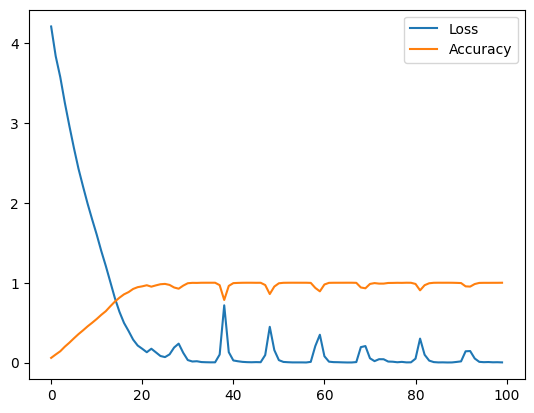

F1-score: 0.9998
Recall: 0.9998
Precision: 0.9998
Accuracy: 0.9998


In [8]:
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

train_losses = []
train_accs = []

epochs = 100

for epoch in range(epochs):
  epoch_loss = 0
  epoch_acc = 0

  for (x, y) in train_loader:
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()

    y_pred = model(x)

    loss = criterion(y_pred, y)

    acc = calculate_accuracy(y_pred, y)

    loss.backward()

    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()


  train_losses.append(epoch_loss / len(train_loader))
  train_accs.append(epoch_acc / len(train_loader))

  print(f'Epoch {epoch+1}: | Loss: {epoch_loss / len(train_loader):.5f} | Acc: {epoch_acc / len(train_loader):.2f}')

# Plot the loss and accuracy
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Loss')
plt.plot(train_accs, label='Accuracy')
plt.legend()
plt.show()

# Calculate other metrics (F1-score, recall, precision)
from sklearn.metrics import f1_score, recall_score, precision_score

# Eğitim sonunda tüm tahminleri ve gerçek etiketleri depolamak için listeler
all_predictions = []
all_labels = []

# Test verileri üzerinde modeli değerlendirme
with torch.no_grad():
  for (x, y) in test_loader:
    x = x.to(device)
    y = y.to(device)

    y_pred = model(x)

    # Tahminleri ve etiketleri listeye ekleme
    all_predictions.extend(y_pred.argmax(1).cpu().numpy())
    all_labels.extend(y.cpu().numpy())

# Metrikleri hesaplama
f1 = f1_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
accuracy = sum(1 for x,y in zip(all_predictions,all_labels) if x == y) / len(all_labels)

print(f'F1-score: {f1:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Accuracy: {accuracy:.4f}')

### Conclusion

- f1, accuracy, recall, precision values are equal. This means that the model performs perfectly for all classes and there is no imbalance or bias between classes. This is mainly due to the use of a ready-made dataset in the torchvision library (CIFAR100).